In [4]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
#os.environ['ARROW_PRE_0_15_IPC_FORMAT'] = '1'

from pyspark.pandas import read_csv
import pyspark.pandas as ps
# means is for items, df is for collab
ps.set_option('compute.default_index_type', 'distributed')
path ='data/item/means.csv'

In [5]:
df = read_csv(path)

In [6]:
df.head()

,streamerId,avgInteractionTime,interactionCounts
0,1000006515845484158,6.553659,10
1,1000006515845484158,6.553659,10
2,1000006515845484158,6.553659,10
3,1000006515845484158,6.553659,10
4,1000006515845484158,6.553659,10


In [7]:
from pyspark.ml.feature import VectorAssembler
spark_df =df.to_spark() 

In [8]:
assemble=VectorAssembler(inputCols=[
'avgInteractionTime', 'interactionCounts'], outputCol='features')
assembled_data=assemble.transform(spark_df)

In [9]:
assembled_data.show(3)

+-------------------+------------------+-----------------+--------------------+
|         streamerId|avgInteractionTime|interactionCounts|            features|
+-------------------+------------------+-----------------+--------------------+
|1000006515845484158| 6.553658536585365|               10|[6.55365853658536...|
|1000006515845484158| 6.553658536585365|               10|[6.55365853658536...|
|1000006515845484158| 6.553658536585365|               10|[6.55365853658536...|
+-------------------+------------------+-----------------+--------------------+
only showing top 3 rows



In [10]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [11]:
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
cost = []
for k in range(2,15):
    print(k)
    kmeans = KMeans().setK(k).setSeed(38).setFeaturesCol("features")
    model = kmeans.fit(data_scale_output.select('streamerId', 'features').sample(False,0.1, seed=38))
    predictions = model.transform(data_scale_output)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    cost.append(silhouette)

2
Silhouette with squared euclidean distance = 0.9753365285110952
3
Silhouette with squared euclidean distance = 0.90366623697643
4
Silhouette with squared euclidean distance = 0.8728519151782558
5
Silhouette with squared euclidean distance = 0.892808496776799
6
Silhouette with squared euclidean distance = 0.8942629101094388
7
Silhouette with squared euclidean distance = 0.8473945584980299
8
Silhouette with squared euclidean distance = 0.8355284290421812
9
Silhouette with squared euclidean distance = 0.8222009472440271
10
Silhouette with squared euclidean distance = 0.8164642506555277
11
Silhouette with squared euclidean distance = 0.8081509020425343
12
Silhouette with squared euclidean distance = 0.808086368906688
13
Silhouette with squared euclidean distance = 0.8040014668564625
14
Silhouette with squared euclidean distance = 0.8046611389269938


Text(0, 0.5, 'cost')

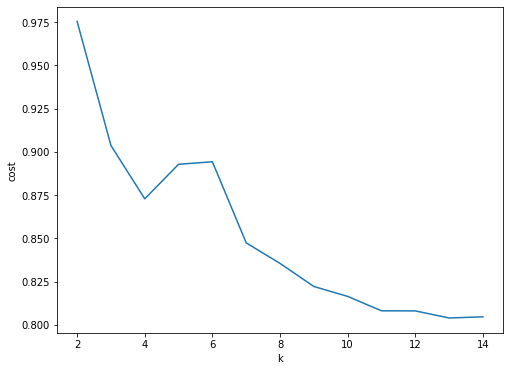

In [12]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,15),cost)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [57]:
kmeans = KMeans().setK(7).setSeed(38).setFeaturesCol("features") # use highest silhouette value
model = kmeans.fit(data_scale_output.select('streamerId', 'features'))
predictions = model.transform(data_scale_output)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance for k = {7}: " + str(silhouette))

Silhouette with squared euclidean distance for k = 7: 0.8476138993901048


In [58]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[   3.7752181  2893.67030356]
[ 3.52288211 78.75841714]
[2.75482951e+00 1.03000000e+04]
[   3.82745023 1471.00072431]
[  3.90116168 618.27026758]
[3.03720308e+00 5.74500000e+03]
[3.00017014e+00 9.10300000e+03]


In [61]:
predictions.show(10, False)

+-------------------+------------------+-----------------+------------------------+----------------------------------------+----------+
|streamerId         |avgInteractionTime|interactionCounts|features                |standardized                            |prediction|
+-------------------+------------------+-----------------+------------------------+----------------------------------------+----------+
|1000006515845484158|6.553658536585365 |10               |[6.553658536585365,10.0]|[3.542307794535726,0.005544908684989901]|1         |
|1000006515845484158|6.553658536585365 |10               |[6.553658536585365,10.0]|[3.542307794535726,0.005544908684989901]|1         |
|1000006515845484158|6.553658536585365 |10               |[6.553658536585365,10.0]|[3.542307794535726,0.005544908684989901]|1         |
|1000006515845484158|6.553658536585365 |10               |[6.553658536585365,10.0]|[3.542307794535726,0.005544908684989901]|1         |
|1000006515845484158|6.553658536585365 |10      

In [62]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
predictions = predictions.withColumn("xs", vector_to_array("standardized"))
predictions_pandas = predictions.to_pandas_on_spark()

In [63]:
predictions_pandas['prediction'].value_counts()

1    436030
4    101154
3     55225
0     34095
2     10300
6      9103
5      5745
Name: prediction, dtype: int64

In [64]:
temp = ps.DataFrame(predictions_pandas['xs'].to_list(), columns=['avgInteractionTimeScaled','interactionCountsScaled'])

In [65]:
temp.head()

,avgInteractionTimeScaled,interactionCountsScaled
0,3.542308,0.005545
1,3.542308,0.005545
2,3.542308,0.005545
3,3.542308,0.005545
4,3.542308,0.005545


In [66]:
final = predictions_pandas.join(temp, how='outer')

In [67]:
final= final.drop(columns=['features','standardized','xs'])

In [68]:
final.head()

,streamerId,avgInteractionTime,interactionCounts,prediction,avgInteractionTimeScaled,interactionCountsScaled
0,1000006515845484158,6.553659,10,1,3.542308,0.005545
1,1000006515845484158,6.553659,10,1,3.542308,0.005545
5,1000006515845484158,6.553659,10,1,3.542308,0.005545
6,1000006515845484158,6.553659,10,1,3.542308,0.005545
7,1000006515845484158,6.553659,10,1,3.542308,0.005545


In [77]:
final.to_spark().coalesce(1).write.format('csv').mode("overwrite").option('header', 'true').save('data/item_predictions')

In [76]:
model.write().overwrite().save('models/kmeans')

In [ ]:
# from pyspark.ml.clustering import KMeansModel
# model2 = KMeansModel.load('models/kmeans')